## 1. Preprocess the dataset

In [1]:
from sklearn.ensemble import VotingClassifier
from sklearn import datasets
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

iris = datasets.load_iris()
X, y = iris.data[50:,[1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.5,random_state=1)


## 2. Evaluate different models

In [2]:
clf1 = LogisticRegression(penalty = 'l2', C = 0.001, random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy',random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

pipe1 = Pipeline([('sc',StandardScaler()), ('clf', clf1)])
pipe3 = Pipeline([('sc',StandardScaler()), ('clf', clf3)])

clf_labels = ['Logistic Regression', 'Decision Tree','KNN']
print('10-fold cross validation:\n')

for clf, label in zip([pipe1,clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring = 'roc_auc')
    print('ROC AUC: %.3f (+/-%.3f) [%s]' % (np.mean(scores), np.std(scores), label))


10-fold cross validation:

ROC AUC: 0.917 (+/-0.201) [Logistic Regression]
ROC AUC: 0.917 (+/-0.154) [Decision Tree]
ROC AUC: 0.933 (+/-0.104) [KNN]


## 3. Compare with ensemble method

In [3]:
mv_clf = VotingClassifier(estimators=[('lr', pipe1),('Tr', clf2),('KNN', pipe3)], voting='soft')
'''
Please refer to http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html 
for details.
'''


clf_labels += ['Majority voting']
all_clf = [pipe1,clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring = 'roc_auc')
    print('ROC AUC: %.3f (+/-%.3f) [%s]' % (np.mean(scores), np.std(scores), label))


ROC AUC: 0.917 (+/-0.201) [Logistic Regression]
ROC AUC: 0.917 (+/-0.154) [Decision Tree]
ROC AUC: 0.933 (+/-0.104) [KNN]
ROC AUC: 0.967 (+/-0.100) [Majority voting]


## 4. Evaluate and tune the ensemble classifier

### 4.1 Evaluate

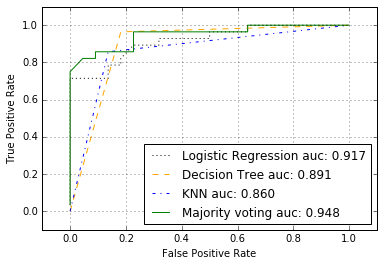

In [6]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline


colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf,clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
    fpr, tpr, threholds = roc_curve(y_true = y_test, y_score = y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color = clr, linestyle = ls,label = '%s auc: %.3f' % (label, roc_auc))
    
plt.legend(loc = 'lower right')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
#plt.show()

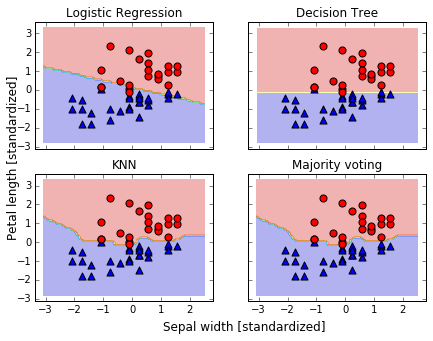

In [9]:
# Visualize the classification on new datasets

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2,sharex='col',sharey='row',figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],X_train_std[y_train==0, 1],c='blue',marker='^',s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],X_train_std[y_train==1, 1],c='red',marker='o',s=50)
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -4.5,s='Sepal width [standardized]',ha='center', va='center', fontsize=12)
plt.text(-11.5, 4.5,s='Petal length [standardized]',ha='center', va='center',fontsize=12, rotation=90)
plt.show()

### 4.2 Tune via grid search

In [10]:
mv_clf.get_params()

{'KNN': Pipeline(steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=1, p=2,
            weights='uniform'))]),
 'KNN__clf': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=1, p=2,
            weights='uniform'),
 'KNN__clf__algorithm': 'auto',
 'KNN__clf__leaf_size': 30,
 'KNN__clf__metric': 'minkowski',
 'KNN__clf__metric_params': None,
 'KNN__clf__n_jobs': 1,
 'KNN__clf__n_neighbors': 1,
 'KNN__clf__p': 2,
 'KNN__clf__weights': 'uniform',
 'KNN__sc': StandardScaler(copy=True, with_mean=True, with_std=True),
 'KNN__sc__copy': True,
 'KNN__sc__with_mean': True,
 'KNN__sc__with_std': True,
 'KNN__steps': [('sc',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('clf',
   KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski

In [15]:
from sklearn.grid_search import GridSearchCV
params = {'Tr__max_depth': [1,2], 'lr__clf__C': [0.001,1,10,100]}
'''
refer to the my_clf.get_params() to see how to get access to the parameters in the ensemble
'''

grid = GridSearchCV(estimator = mv_clf, param_grid=params,cv=10, scoring = 'roc_auc')
grid.fit(X_train,y_train)

print('Best parameters: %s' % grid.best_params_)
print('Best score: %.3f' % grid.best_score_)

grid.grid_scores_

Best parameters: {'lr__clf__C': 1, 'Tr__max_depth': 1}
Best score: 1.000


[mean: 0.96667, std: 0.10000, params: {'lr__clf__C': 0.001, 'Tr__max_depth': 1},
 mean: 1.00000, std: 0.00000, params: {'lr__clf__C': 1, 'Tr__max_depth': 1},
 mean: 1.00000, std: 0.00000, params: {'lr__clf__C': 10, 'Tr__max_depth': 1},
 mean: 1.00000, std: 0.00000, params: {'lr__clf__C': 100, 'Tr__max_depth': 1},
 mean: 0.96667, std: 0.10000, params: {'lr__clf__C': 0.001, 'Tr__max_depth': 2},
 mean: 1.00000, std: 0.00000, params: {'lr__clf__C': 1, 'Tr__max_depth': 2},
 mean: 1.00000, std: 0.00000, params: {'lr__clf__C': 10, 'Tr__max_depth': 2},
 mean: 1.00000, std: 0.00000, params: {'lr__clf__C': 100, 'Tr__max_depth': 2}]

# 5. Bagging/Bootstrap Aggregating

In [16]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol','Malic acid', 'Ash','Alcalinity of ash','Magnesium', 'Total phenols','Flavanoids', 'Nonflavanoid phenols','Proanthocyanins','Color intensity', 'Hue','OD280/OD315 of diluted wines','Proline']
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Hue']].values

from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test =train_test_split(X, y,test_size=0.40,random_state=1)

In [17]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
tree = DecisionTreeClassifier(criterion='entropy',max_depth=None)
bag = BaggingClassifier(base_estimator=tree,n_estimators=500,max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False,n_jobs=1,random_state=1)
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f'% (bag_train, bag_test))

Bagging train/test accuracies 1.000/0.896


# 6. Adaptive Boosting (Adaboost)

In [18]:
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
ada = AdaBoostClassifier(base_estimator=tree,n_estimators=500,learning_rate=0.1,random_state=0)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))


ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost train/test accuracies %.3f/%.3f'% (ada_train, ada_test))

Decision tree train/test accuracies 0.845/0.854
AdaBoost train/test accuracies 1.000/0.875
